In [123]:
import matplotlib as plt
from matplotlib.pyplot import imshow, show
import h5py

In [124]:
hdf5_path = "./output/97.hdf5"

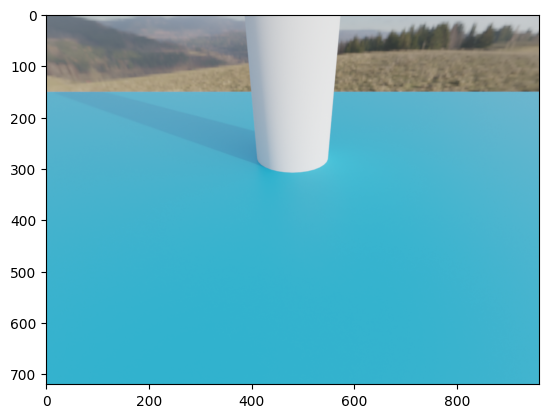

ride_height: [-2.4990172]


In [125]:
 
with h5py.File(hdf5_path, "r") as f:
    for name, ds in f.items():
        if name == "ride_height":
            print(f"ride_height: {ds[:]}")
        if hasattr(ds, "shape") and ds.ndim >= 2:
            imshow(ds[:])
            show()


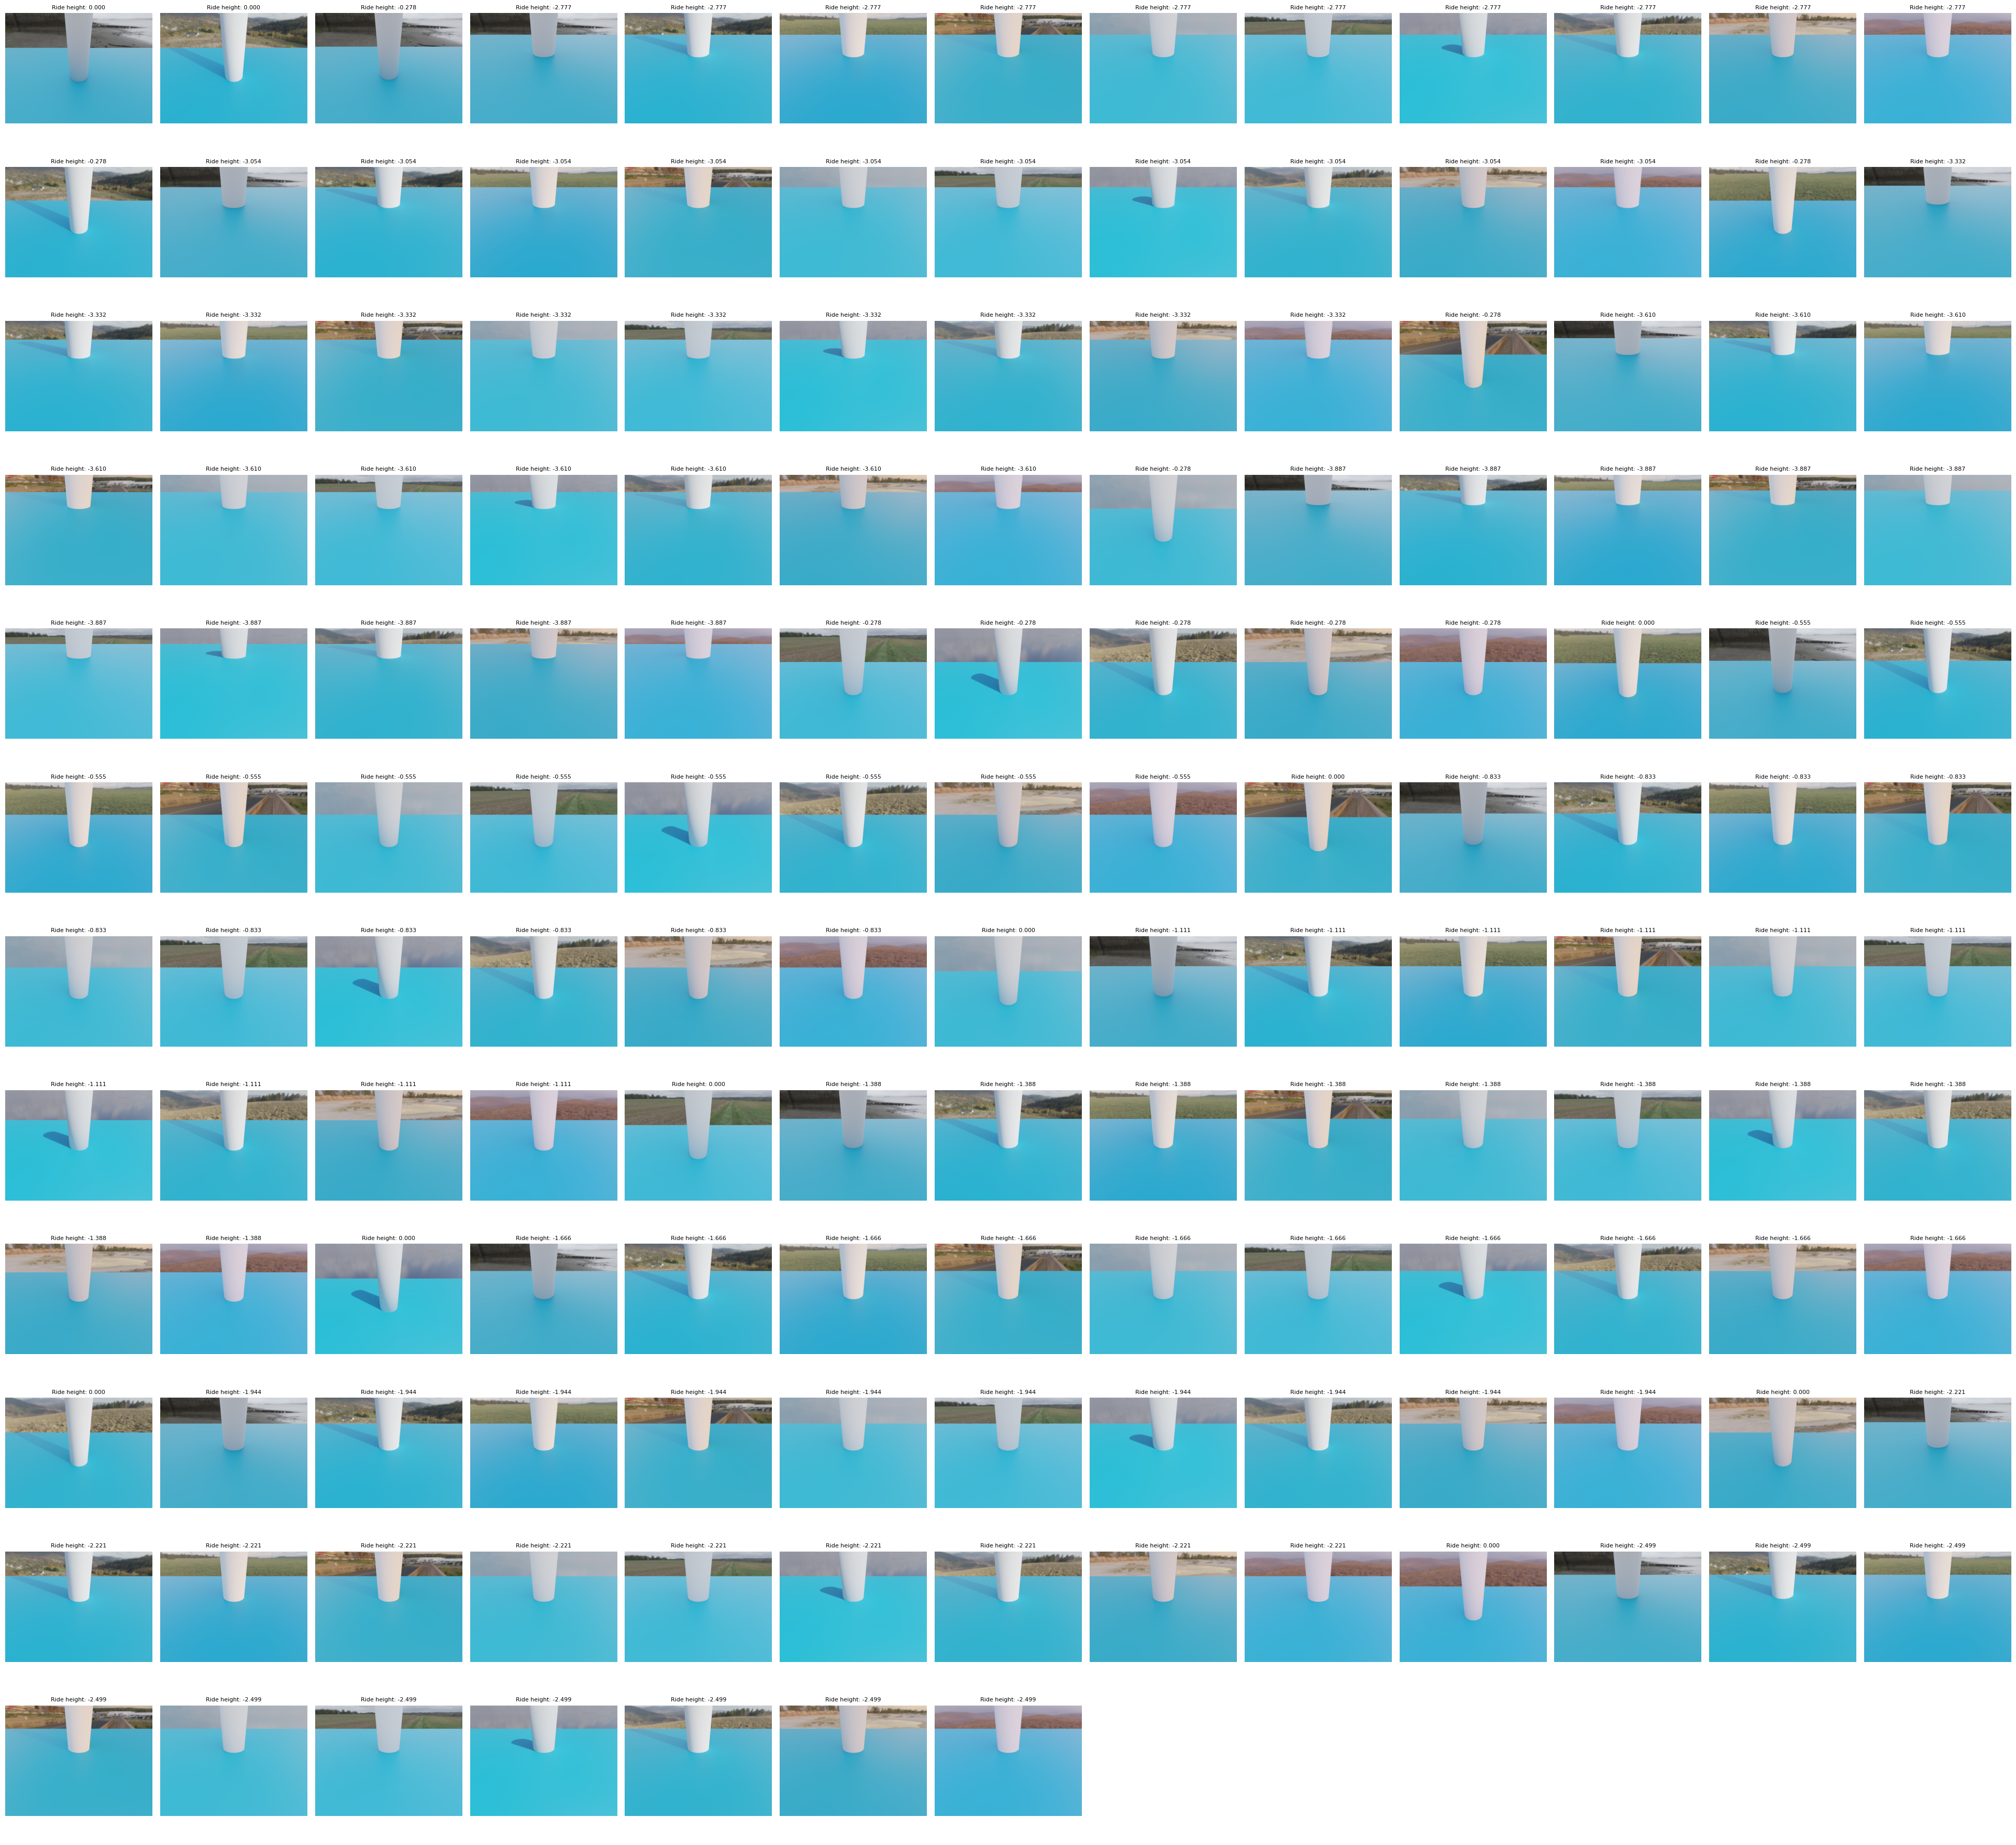

In [126]:
# Display HDF5 images in a grid

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt


def load_images_from_hdf5(output_dir='output', max_images=None):
    files = sorted([f for f in os.listdir(output_dir) if f.endswith('.hdf5')])
    images = []
    titles = []

    for fn in files:
        path = os.path.join(output_dir, fn)
        try:
            with h5py.File(path, 'r') as f:
                img = None
                ride_val = None

                def visitor(name, obj):
                    nonlocal img, ride_val
                    if isinstance(obj, h5py.Dataset):
                        try:
                            data = obj[()]
                        except Exception:
                            return
                        if img is None and getattr(data, 'ndim', 0) == 3 and data.shape[2] in (3, 4):
                            img = data
                        if ride_val is None and ('ride' in name.lower() or 'height' in name.lower()):
                            try:
                                ride_val = float(np.array(data).squeeze())
                            except Exception:
                                ride_val = str(data)

                f.visititems(visitor)

                # fallback to common keys if not found
                if img is None:
                    for key in ('colors', 'rgba', 'image', 'rgb'):
                        if key in f:
                            try:
                                data = f[key][()]
                                if getattr(data, 'ndim', 0) == 3 and data.shape[2] in (3, 4):
                                    img = data
                                    break
                            except Exception:
                                continue

                if img is None:
                    continue

                # normalize floats to 0-255
                if img.dtype.kind == 'f':
                    img = np.clip(img, 0.0, 1.0)
                    img = (img * 255.0).astype('uint8')
                if img.shape[2] == 4:
                    img = img[:, :, :3]

                images.append(img)

                if ride_val is None:
                    base = os.path.splitext(os.path.basename(path))[0]
                    try:
                        ride_val = float(base)
                    except Exception:
                        ride_val = base

                titles.append(f"Ride height: {ride_val:.3f}" if isinstance(ride_val, (int, float)) else f"Ride: {ride_val}")

                if max_images is not None and len(images) >= max_images:
                    break

        except Exception as e:
            print(f"Error reading {path}: {e}")

    return images, titles


images, titles = load_images_from_hdf5('./output')

if not images:
    print('No images found in ./output to display')
else:
    N = len(images)
    cols = int(np.ceil(np.sqrt(N)))
    rows = int(np.ceil(N / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)

    for i, ax in enumerate(axes):
        if i >= N:
            ax.axis('off')
            continue
        ax.imshow(images[i])
        ax.set_title(titles[i], fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
